# Azure Cognitive Services で AI プログラミング

## 0. 準備 - Cognitive Services 接続情報を確認

このハンズオンでは Azure Cognitive Services で提供されている **事前構築済みの AI** を利用して AI 開発を体験します。

最初に Cognitive Services の接続情報が正しく設定されているかを確認します。

> 集合形式のハンズオンではあらかじめ接続情報が設定されているかもしれません。  
> その場合は、以下のセルを実行すると、エンドポイントとキーの値が表示されます。
>
> [**Cognitive リソースの作成**](./a01_createcog.ipynb) および [**ハンズオンの環境構築**](./0_setup.ipynb) を実施する必要があります。

In [1]:
from dotenv import load_dotenv
import os

In [2]:
# Cognitive Services 利用のために Endpoint と Key とを読み込みます
load_dotenv()
cog_endpoint = os.getenv('COG_SERVICE_ENDPOINT')
cog_key = os.getenv('COG_SERVICE_KEY')

In [3]:
print("Endpoint: " + cog_endpoint)
print("Key: " + cog_key)

Endpoint: https://occogdev.cognitiveservices.azure.com/
Key: e9311b33dbd0441394ccc594dd3a916c


---

## 1. 画像分析

In [4]:
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from msrest.authentication import CognitiveServicesCredentials
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [5]:
# 画像のパスを決定
image_path = os.path.join('data', 'vision', 'image1.jpg')

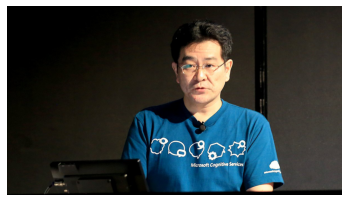

In [6]:
img = Image.open(image_path)
plt.axis('off')
plt.imshow(img)

In [7]:
# Get a client for the computer vision service
computervision_client = ComputerVisionClient(cog_endpoint, CognitiveServicesCredentials(cog_key))

# Get a description from the computer vision service
image_stream = open(image_path, "rb")
#description = computervision_client.describe_image_in_stream(image_stream)
description = computervision_client.describe_image_in_stream(image_stream, language="ja")

In [8]:
print(description)

{'additional_properties': {}, 'tags': ['人', '男', '屋内', 'シャツ', '衣類', '探す', 'テーブル', 'フロント', 'ノートパソコン', '座る', 'ブルー', '若い', '立つ', '持つ', 'コンピュータ', '微笑み', 'メガネ', 'リモコン', '紫', '食品', '部屋', 'ビデオ'], 'captions': [<azure.cognitiveservices.vision.computervision.models._models_py3.ImageCaption object at 0x00000139B02D75E0>], 'request_id': 'cd502525-a88a-4ffd-b6a2-11a95f907899', 'metadata': <azure.cognitiveservices.vision.computervision.models._models_py3.ImageMetadata object at 0x00000139AD8E8640>, 'model_version': '2021-05-01'}


In [9]:
for tag in description.tags:
    print(tag)

人
男
屋内
シャツ
衣類
探す
テーブル
フロント
ノートパソコン
座る
ブルー
若い
立つ
持つ
コンピュータ
微笑み
メガネ
リモコン
紫
食品
部屋
ビデオ


In [10]:
#print(description.captions[0].text)

for caption in description.captions:
    print(caption.text)

青いシャツを着た男性


In [12]:
image_stream = open(image_path, "rb")

# Specify the features we want to analyze
features = ['Description', 'Tags', 'Adult', 'Objects', 'Faces']
analysis = computervision_client.analyze_image_in_stream(image_stream, visual_features=features)
#analysis = computervision_client.analyze_image_in_stream(image_stream, visual_features=features, language="ja")

In [13]:
print(analysis)

{'additional_properties': {}, 'categories': None, 'adult': <azure.cognitiveservices.vision.computervision.models._models_py3.AdultInfo object at 0x00000139B0285AF0>, 'color': None, 'image_type': None, 'tags': [<azure.cognitiveservices.vision.computervision.models._models_py3.ImageTag object at 0x00000139B02B6430>, <azure.cognitiveservices.vision.computervision.models._models_py3.ImageTag object at 0x00000139B02B6400>, <azure.cognitiveservices.vision.computervision.models._models_py3.ImageTag object at 0x00000139B028B1C0>, <azure.cognitiveservices.vision.computervision.models._models_py3.ImageTag object at 0x00000139B028BA90>, <azure.cognitiveservices.vision.computervision.models._models_py3.ImageTag object at 0x00000139B028BB50>, <azure.cognitiveservices.vision.computervision.models._models_py3.ImageTag object at 0x00000139B028B820>, <azure.cognitiveservices.vision.computervision.models._models_py3.ImageTag object at 0x00000139B028B190>, <azure.cognitiveservices.vision.computervision.m

In [ ]:
caption_text = ""

if (len(description.captions) == 0):
    caption_text = 'No caption detected'
else:
    for caption in description.captions:
        caption_text = caption_text + " '{}'\n(Confidence: {:.2f}%)".format(caption.text, caption.confidence * 100)